In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


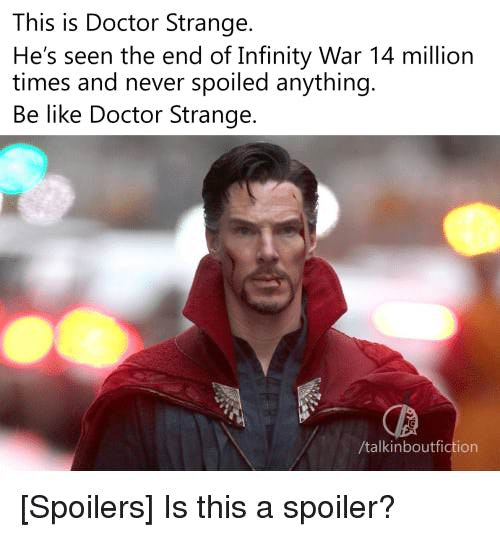

In [2]:

from IPython.display import Image
Image('/content/gdrive/My Drive/Meme-Dataset/train/meme/12.jpg')

In [0]:
import torch
import pickle as pkl
from matplotlib import pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torchvision import datasets
import os

In [0]:
def get_data(batch_size,image_size,path='/content/gdrive/My Drive/Meme-Dataset/'):
  
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
  
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        normalization
    ])
    
    dataset_train = datasets.ImageFolder(os.path.join(path,'train'),transform = transform)
    dataset_test = datasets.ImageFolder(os.path.join(path,'test'),transform = transform)
    
    dataloader_train = torch.utils.data.DataLoader(dataset = dataset_train,batch_size = batch_size,shuffle=True)  
    dataloader_test = torch.utils.data.DataLoader(dataset = dataset_test,batch_size = batch_size,shuffle=True)  
    
    return dataloader_train,dataloader_test
  
data_train,data_test = get_data(50,512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


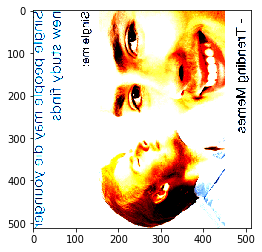

In [20]:
for idx,(data,label) in enumerate(data_train):
  if idx == 1 :
    print(label[7])
    npimg = data[7].numpy()
    plt.imshow(np.transpose(npimg))
    break

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [6]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

use_cuda = torch.cuda.is_available()

print(use_cuda)

if use_cuda:
  model = model.cuda()


True


In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
model.classifier = nn.Sequential(nn.Linear(25088,4096),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(4096,128),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(128,2))

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [0]:
def train(epochs,loaders,model,optimizer,criterion,use_cuda,path):
  
  for epoch in range(0,epochs+1):
    
    train_loss = 0.0
    
    model.train()
    
    for idx,(data,target) in enumerate(loaders):
      
      if use_cuda :
        
        data = data.cuda()
        target = target.cuda()
        
      optimizer.zero_grad()
      
      output = model(data)
      
      loss = criterion(output,target)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss = train_loss + ((1 / (idx +1)) * (loss.data - train_loss))
      
      if idx % 5 == 0:
        print('Epoch %d,Batch %d,Loss %.6f'% (epoch,idx,train_loss))
        idx += 1
        
      if epoch % 5 == 0:
        torch.save(model.state_dict(),path)
        
  return model

In [30]:
epochs = 10

model.cuda()

path = 'meme_model.pt'

train(epochs,data_train,model,optimizer,criterion,use_cuda,path)

model.load_state_dict(torch.load(path))

Epoch 0,Batch 0,Loss 0.262473
Epoch 0,Batch 5,Loss 0.264655


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 0,Batch 10,Loss 0.231643
Epoch 0,Batch 15,Loss 0.247782
Epoch 0,Batch 20,Loss 0.234845
Epoch 0,Batch 25,Loss 0.220715
Epoch 0,Batch 30,Loss 0.213520
Epoch 1,Batch 0,Loss 0.066115
Epoch 1,Batch 5,Loss 0.099236
Epoch 1,Batch 10,Loss 0.097199
Epoch 1,Batch 15,Loss 0.094335
Epoch 1,Batch 20,Loss 0.087897
Epoch 1,Batch 25,Loss 0.083181
Epoch 1,Batch 30,Loss 0.090831
Epoch 2,Batch 0,Loss 0.043060
Epoch 2,Batch 5,Loss 0.043081
Epoch 2,Batch 10,Loss 0.038958
Epoch 2,Batch 15,Loss 0.037823
Epoch 2,Batch 20,Loss 0.032925
Epoch 2,Batch 25,Loss 0.031195
Epoch 2,Batch 30,Loss 0.029535
Epoch 3,Batch 0,Loss 0.006456
Epoch 3,Batch 5,Loss 0.017032
Epoch 3,Batch 10,Loss 0.013262
Epoch 3,Batch 15,Loss 0.012380
Epoch 3,Batch 20,Loss 0.014244
Epoch 3,Batch 25,Loss 0.013051
Epoch 3,Batch 30,Loss 0.012156
Epoch 4,Batch 0,Loss 0.008816
Epoch 4,Batch 5,Loss 0.005190
Epoch 4,Batch 10,Loss 0.004360
Epoch 4,Batch 15,Loss 0.004441
Epoch 4,Batch 20,Loss 0.006928
Epoch 4,Batch 25,Loss 0.006120
Epoch 4,Batch 30

In [0]:
model.load_state_dict(torch.load('meme_model.pt'))

In [0]:
def test(loaders,model,criterion,use_cuda):
  
  test_loss = 0.
  correct = 0.
  total = 0.
  
  model.eval()
  
  for idx ,(data,target) in enumerate(loaders):
    
    if use_cuda:
      
      data = data.cuda()
      target = target.cuda()
      
    output = model(data)
    
    loss = criterion(output,target)
    
    test_loss = test_loss + ((1 / (idx +1)) * (loss.data - test_loss))
    
    pred = output.data.max(1, keepdim=True)[1]
    
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        
    total += data.size(0)
    
  print('Test Loss: %.6f\n'%(test_loss))

  print('Test Accuracy: %2d%% (%2d/%2d)' % ((100. * correct/total),correct,total))

In [15]:
model.cuda()

test(data_test,model,criterion,use_cuda)

Test Loss: 0.194455

Test Accuracy: 94% (579/610)


In [0]:
torch.save(model.state_dict(),'/content/gdrive/My Drive/Meme-Dataset/meme_model.pt')